In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, pairwise_distances, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

In [92]:
# Step 1: Load Dataset
file_path = '/kaggle/input/iris-all/Iris.csv'
data = pd.read_csv(file_path)
print("Dataset Loaded Successfully!")

# Display the first few rows of the dataset
print("\nOriginal Dataset (First 5 rows):")
print(data.head())

# Save original dataset for comparison
original_data = data.copy()

Dataset Loaded Successfully!

Original Dataset (First 5 rows):
   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


In [142]:
# Step 2: Introduce 10% Missing Values
data_with_missing = data.copy()
num_samples, num_features = data_with_missing.shape
missing_count = int(0.1 * num_samples * (num_features - 1))  # 10% of the total data points (excluding species)

# Randomly select positions to introduce missingness
missing_indices = [
    (np.random.randint(0, num_samples), np.random.randint(0, num_features - 1))  # Exclude 'species' column
    for _ in range(missing_count)
]

for row, col in missing_indices:
    data_with_missing.iloc[row, col] = np.nan

print(f"\nData with 10% Missing Values (First 5 rows):")
print(data_with_missing.head())


Data with 10% Missing Values (First 5 rows):
    Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0  1.0            5.1           3.5            1.4           0.2  Iris-setosa
1  2.0            4.9           3.0            1.4           0.2  Iris-setosa
2  3.0            4.7           3.2            1.3           0.2  Iris-setosa
3  4.0            4.6           3.1            1.5           0.2  Iris-setosa
4  5.0            5.0           3.6            1.4           0.2  Iris-setosa


In [143]:
# Step 3: Calculate Covariance Matrix (Numerical Columns Only)
numerical_columns = data_with_missing.select_dtypes(include=[np.number]).columns
cov_matrix = data_with_missing[numerical_columns].cov()
print("\nCovariance Matrix with Missing Values:")
print(cov_matrix)


Covariance Matrix with Missing Values:
                        Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  \
Id             1923.993165      27.525216     -8.291665      68.373674   
SepalLengthCm    27.525216       0.675255     -0.040667       1.253615   
SepalWidthCm     -8.291665      -0.040667      0.198035      -0.326675   
PetalLengthCm    68.373674       1.253615     -0.326675       3.037536   
PetalWidthCm     30.046219       0.525914     -0.127308       1.283448   

               PetalWidthCm  
Id                30.046219  
SepalLengthCm      0.525914  
SepalWidthCm      -0.127308  
PetalLengthCm      1.283448  
PetalWidthCm       0.588217  


In [144]:
# Step 4: Impute Missing Data (Only on Missing Values)
imputed_data = data_with_missing.copy()

# Impute only the missing values with the mean of each column
for column in numerical_columns:
    imputed_data[column] = imputed_data[column].apply(
        lambda x: np.nan if pd.isna(x) else x  # Keep original non-missing values
    )
    imputed_data[column] = imputed_data[column].fillna(imputed_data[column].mean())

print("\nImputed Data (First 5 rows):")
print(imputed_data.head())


Imputed Data (First 5 rows):
    Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0  1.0            5.1           3.5            1.4           0.2  Iris-setosa
1  2.0            4.9           3.0            1.4           0.2  Iris-setosa
2  3.0            4.7           3.2            1.3           0.2  Iris-setosa
3  4.0            4.6           3.1            1.5           0.2  Iris-setosa
4  5.0            5.0           3.6            1.4           0.2  Iris-setosa


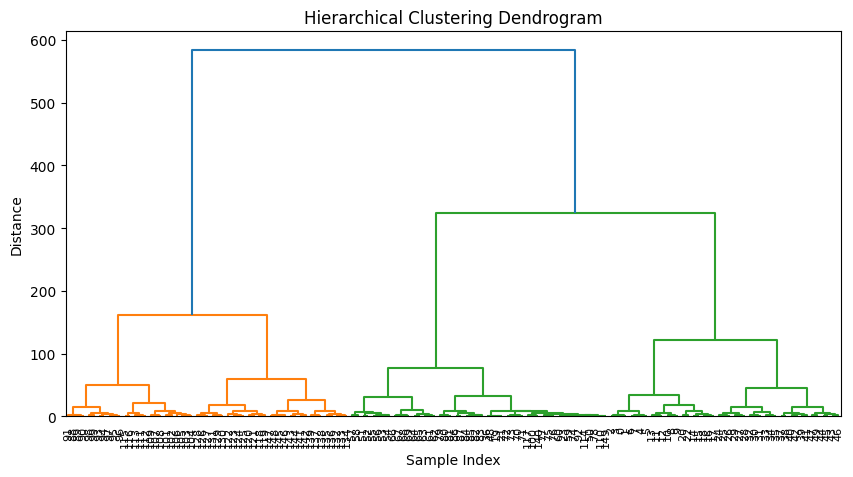


Cluster Labels Assigned to Data:
Cluster
1    55
2    50
3    45
Name: count, dtype: int64


In [145]:
# Step 5: Cluster Data Using Hierarchical Clustering
linkage_matrix = linkage(imputed_data[numerical_columns], method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=8)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# Assign clusters (e.g., 3 clusters for demonstration)
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
imputed_data['Cluster'] = cluster_labels
print("\nCluster Labels Assigned to Data:")
print(imputed_data['Cluster'].value_counts())

In [146]:
# Step 6: Covariance Adjustment
def adjust_imputed_data(imputed_data, original_data):
    """
    Adjust imputed data to match the original covariance structure.
    Parameters:
        imputed_data (pd.DataFrame): Data with missing values imputed.
        original_data (pd.DataFrame): Original data without missing values.
    Returns:
        pd.DataFrame: Adjusted imputed data.
    """
    adjusted_data = imputed_data.copy()
    num_features = len(numerical_columns)
    
    for feature in numerical_columns:
        adjustment_factor = (
            original_data[feature].std() / adjusted_data[feature].std()
            if adjusted_data[feature].std() != 0
            else 1
        )
        adjusted_data[feature] *= adjustment_factor
    
    for feature in numerical_columns:
        adjusted_data[feature] += original_data[feature].mean() - adjusted_data[feature].mean()
    
    return adjusted_data.iloc[:, :-1]  # Exclude 'Cluster' column

final_imputed_data = adjust_imputed_data(imputed_data, original_data)

In [147]:
# Step 8: Display Final Imputed Data
print("\nFinal Imputed Data (First 5 rows):")
print(final_imputed_data.head())


Final Imputed Data (First 5 rows):
         Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0 -2.711915       5.093796      3.494983       1.102794      0.181729   
1 -1.659595       4.884378      2.990591       1.102794      0.181729   
2 -0.607275       4.674960      3.192348       0.994825      0.181729   
3  0.445046       4.570251      3.091469       1.210763      0.181729   
4  1.497366       4.989087      3.595861       1.102794      0.181729   

       Species  
0  Iris-setosa  
1  Iris-setosa  
2  Iris-setosa  
3  Iris-setosa  
4  Iris-setosa  


In [148]:

# Validate: Compare final imputed data with original data
print("\nDifference Between Final Imputed Data and Original Data:")
print((final_imputed_data[numerical_columns] - original_data[numerical_columns]).abs().mean())


Difference Between Final Imputed Data and Original Data:
Id               5.658243
SepalLengthCm    0.092018
SepalWidthCm     0.021097
PetalLengthCm    0.325045
PetalWidthCm     0.089207
dtype: float64


In [151]:
# Step 7: Silhouette Score Calculation
silhouette_avg = silhouette_score(
    imputed_data[numerical_columns], cluster_labels
)
print(f"\nSilhouette Score for Clustering: {silhouette_avg:.4f}")


Silhouette Score for Clustering: 0.5830


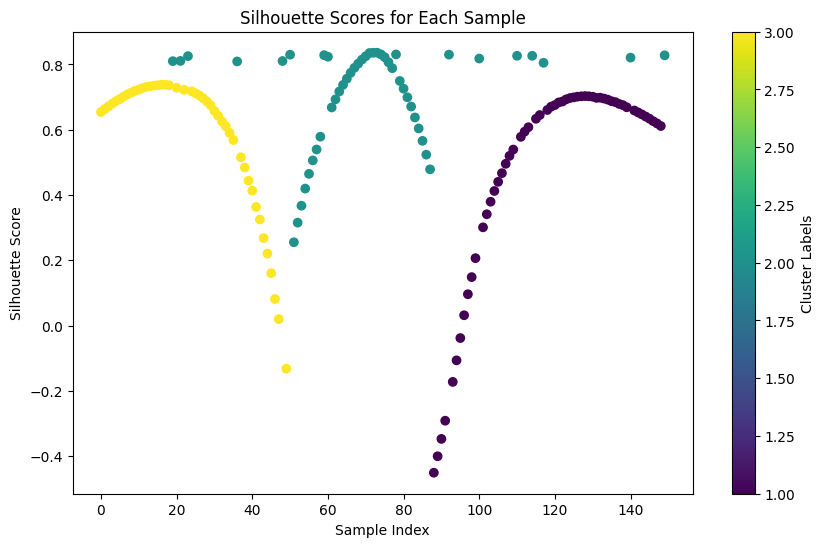

In [152]:
# Step 5: Calculate Silhouette Score for Each Sample
silhouette_vals = silhouette_samples(imputed_data[numerical_columns], cluster_labels)

# Step 6: Visualize Silhouette Score
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(silhouette_vals)), silhouette_vals, c=cluster_labels, cmap='viridis', marker='o')
plt.xlabel("Sample Index")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Each Sample")
plt.colorbar(label='Cluster Labels')
plt.show()

In [153]:
# Step 8: Davies-Bouldin Index
dbi = davies_bouldin_score(
    imputed_data[numerical_columns], cluster_labels
)
print(f"Davies-Bouldin Index for Clustering: {dbi:.4f}")

Davies-Bouldin Index for Clustering: 0.4696


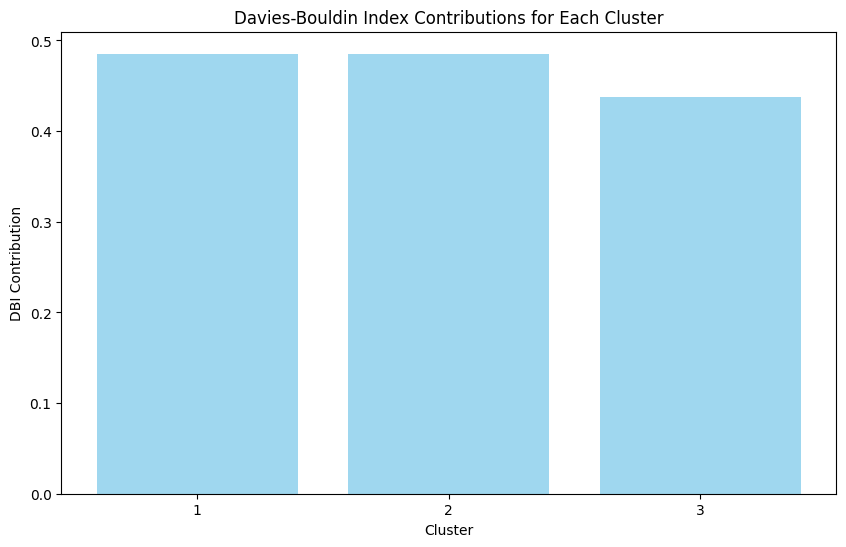

In [155]:
# Step: Calculate DBI contributions for each cluster
def calculate_dbi_contributions(data, cluster_labels, num_clusters):
    """
    Calculate DBI contribution for each cluster.
    Parameters:
        data (pd.DataFrame): Input data (numerical features only).
        cluster_labels (array-like): Cluster labels for each sample.
        num_clusters (int): Total number of clusters.
    Returns:
        list: DBI contributions for each cluster.
    """
    centroids = [
    data[cluster_labels == i].mean(axis=0)
    for i in range(1, num_clusters + 1)
    ]
    s = [
        np.mean(pairwise_distances(data[cluster_labels == i], [centroids[i - 1]]))
        for i in range(1, num_clusters + 1)
    ]
    dbi_contributions = []
    for i in range(num_clusters):
        max_ratio = 0
        for j in range(num_clusters):
            if i != j:
                ratio = (s[i] + s[j]) / np.linalg.norm(centroids[i] - centroids[j])
                max_ratio = max(max_ratio, ratio)
        dbi_contributions.append(max_ratio)
    return dbi_contributions

# Calculate DBI contributions
dbi_contributions = calculate_dbi_contributions(
    imputed_data[numerical_columns].to_numpy(), 
    cluster_labels, 
    num_clusters
)

# Step: Visualize DBI contributions
plt.figure(figsize=(10, 6))
plt.bar(range(1, num_clusters + 1), dbi_contributions, color='skyblue', alpha=0.8)
plt.xlabel("Cluster")
plt.ylabel("DBI Contribution")
plt.title("Davies-Bouldin Index Contributions for Each Cluster")
plt.xticks(range(1, num_clusters + 1))
plt.show()


In [157]:
# Calculate the CH Index for the clustered data
ch_index = calinski_harabasz_score(imputed_data[numerical_columns], cluster_labels)

# Print the Calinski-Harabasz Index value
print(f"Calinski-Harabasz Index: {ch_index}")

Calinski-Harabasz Index: 521.4502898002042


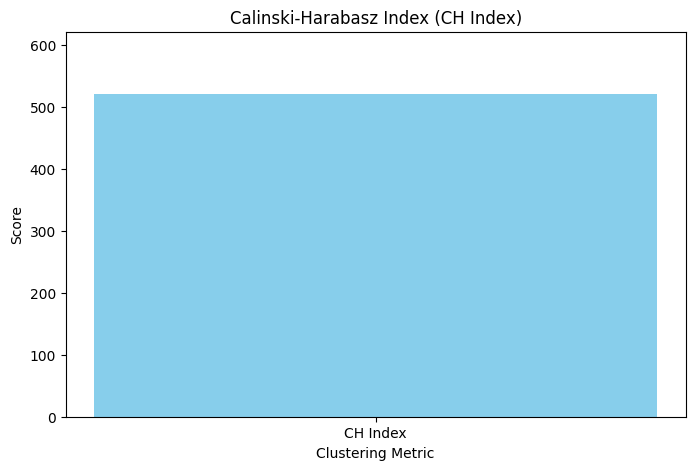

In [159]:
# Assuming your CH Index value is stored in the variable `chi_value`
chi_value = ch_index  # Replace this with your actual CH Index value

# Step 1: Prepare data for the bar plot
chi_labels = ['CH Index']
chi_scores = [chi_value]

# Step 2: Plotting the bar graph
plt.figure(figsize=(8, 5))
plt.bar(chi_labels, chi_scores, color='skyblue')
plt.xlabel('Clustering Metric')
plt.ylabel('Score')
plt.title('Calinski-Harabasz Index (CH Index)')
plt.ylim(0, max(chi_scores) + 100)  # Adjust the y-axis for better visualization

# Display the plot
plt.show()
